# A RBMK geometry 
This notebook can be used as a template for modeling RBMK reactors.

SOURCES
"Fuel Assembly": https://web.archive.org/web/20090908013425/http:/www.insc.anl.gov:80/rbmk/reactor/assembly.html
"Fuel with burnable absorber for RBMK-1500", pg250-252: https://www.osti.gov/etdeweb/servlets/purl/20269236
"DESIGN AND FABRICATION OF NUCLEAR FUEL FOR WWER AND RBMK REACTORS"
Slides 8-11: indico.ictp.it/event/a04215/session/26/contribution/16/material/0/1.pdf
"RBMK" https://en.wikipedia.org/wiki/RBMK#:~:text=The%20blocks%20are%20stacked%2C%20surrounded,diameter%20by%207%20m%20height.

In [1]:
%matplotlib inline
from math import pi, sin, cos, sqrt
import numpy as np
import openmc

In [2]:
# Materials definitions

fuel = openmc.Material(name='2.0% Fuel')
fuel.add_element('U', 0.995, enrichment=2.0)
fuel.add_element('Er', 0.005)
fuel.add_nuclide('O16', 2.0)
fuel.set_density('g/cm3', 10.400)

zircaloy = openmc.Material(name='Zircaloy')
zircaloy.add_element('Zr', 0.99)
zircaloy.add_element('Nb', 0.01)
zircaloy.set_density('g/cm3', 8.59)

wall = openmc.Material(name='Carrier Rod Material')
wall.add_element('Zr', 0.975)
wall.add_element('Nb', 0.025)
wall.set_density('g/cm3', 8.59)

helium = openmc.Material(name='Helium')
helium.add_element('He', 1)
helium.set_density('g/cm3', 0.178)

absorber = openmc.Material(name='B4C')
absorber.add_element('B', 4)
absorber.add_element('C', 1)
absorber.set_density('g/cm3', 2.52)

graphite = openmc.Material(name='Graphite')
graphite.add_element('C', 1.0)
graphite.set_density('g/cm3', 1.7)

concrete = openmc.Material(name='Concrete')
concrete.add_element('H',  0.149857)
concrete.add_element('C',  0.074206)
concrete.add_element('O',  0.526836)
concrete.add_element('Mg', 0.017713)
concrete.add_element('Al', 0.023794)
concrete.add_element('Si', 0.091975)
concrete.add_element('S',  0.001649)
concrete.add_element('K',  0.000773)
concrete.add_element('Ca', 0.109681)
concrete.add_element('Fe', 0.003516)
concrete.set_density('g/cm3', 2.35)

# Instantiate a Materials collection and export to xml
materials_file = openmc.Materials([fuel, zircaloy, helium, wall, absorber, graphite, concrete])
materials_file.export_to_xml()

In [3]:
x_min = openmc.XPlane(x0=0,      boundary_type='vacuum')
x_max = openmc.XPlane(x0=11.8,   boundary_type='vacuum')
y_min = openmc.YPlane(y0=0,      boundary_type='vacuum')
y_max = openmc.YPlane(y0=11.8,   boundary_type='vacuum')
z_min = openmc.ZPlane(z0=0,      boundary_type='vacuum')
z_max = openmc.ZPlane(z0=7,      boundary_type='vacuum')

# Combine the boundary planes to form a cuboid region
reactor_boundary = (+x_min & -x_max & +y_min & -y_max & +z_min & -z_max)

In [5]:
# Create the lattice position for it to fill
assembly_x = .245833
assembly_y = .245833
assembly_z = 7

# Define the fuel region with a single cylinder per hole
z_plane_start  = openmc.ZPlane(z0=0)
z_plane_height = openmc.ZPlane(z0=assembly_z)
z_plane_end    = openmc.ZPlane(z0=assembly_z)

In [6]:
# Create the concrete bricks surrounding the core
concrete_x = .245833
concrete_y = .245833
concrete_z = 7

z_plane_end = openmc.ZPlane(z0=assembly_z)

#Concrete Bricks
concrete_assembly_block = openmc.model.rectangular_prism(width=concrete_x, height=concrete_y)
concrete_assembly_block_cell = openmc.Cell(name='Concrete_bricks')
concrete_assembly_block_cell.fill = concrete
concrete_assembly_block_cell.region = concrete_assembly_block & -z_plane_end & +z_min

concrete_assembly_universe = openmc.Universe(cells=[concrete_assembly_block_cell])

/openmc_venv/lib/python3.11/site-packages/openmc/model/funcs.py:114: FutureWarning: The rectangular_prism(...) function has been replaced by the RectangularPrism(...) class. Future versions of OpenMC will not accept rectangular_prism.
  warn("The rectangular_prism(...) function has been replaced by the "


<Axes: xlabel='x [cm]', ylabel='y [cm]'>

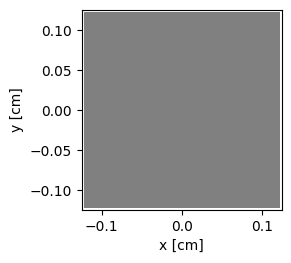

In [7]:
concrete_assembly_universe.plot(width=(.25, .25), basis='xy', colors = {concrete_assembly_block_cell:'gray'})

In [8]:
# Create the concrete bricks surrounding the core
absorber_x = .245833
absorber_y = .245833
absorber_z = 7

z_plane_end    = openmc.ZPlane(z0=assembly_z)

#Concrete Bricks
absorber_assembly_block = openmc.model.rectangular_prism(width=absorber_x, height=absorber_y)
absorber_assembly_block_cell = openmc.Cell(name='Absorber_bricks')
absorber_assembly_block_cell.fill = absorber
absorber_assembly_block_cell.region = absorber_assembly_block & -z_plane_end & +z_min

absorber_assembly_universe = openmc.Universe(cells=[absorber_assembly_block_cell])

/openmc_venv/lib/python3.11/site-packages/openmc/model/funcs.py:114: FutureWarning: The rectangular_prism(...) function has been replaced by the RectangularPrism(...) class. Future versions of OpenMC will not accept rectangular_prism.
  warn("The rectangular_prism(...) function has been replaced by the "


<Axes: xlabel='x [cm]', ylabel='y [cm]'>

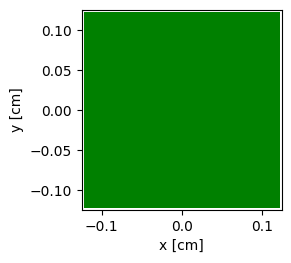

In [9]:
absorber_assembly_universe.plot(width=(.25, .25), basis='xy', colors = {absorber_assembly_block_cell:'green'})

In [10]:
# Geometry definitions for the fuel rod

#Making the boundary planes for the sleeves
sleeve_min_z = openmc.ZPlane(z0=-12)
sleeve_max_z = openmc.ZPlane(z0=+12)

# Create cylinders for the fuel and clad
fuel_inner_radius = openmc.ZCylinder(r=0.0055)
fuel_outer_radius = openmc.ZCylinder(r=0.00566)
clad_inner_radius = openmc.ZCylinder(r=0.00596)
clad_outer_radius = openmc.ZCylinder(r=0.0068)

# Create a universe to encapsulate a fuel rod
pin_cell_universe = openmc.Universe(name='2.0% Fuel Pin') 

# Create fuel cell
fuel_cell_top = openmc.Cell(name='2.0% Fuel')
fuel_cell_top.fill = fuel
fuel_cell_top.region = -fuel_inner_radius & +sleeve_max_z
pin_cell_universe.add_cell(fuel_cell_top)

# Create void space
void_space_top = openmc.Cell(name='empty_space')
void_space_top.fill = helium
void_space_top.region = +fuel_inner_radius & -clad_inner_radius & +sleeve_max_z
pin_cell_universe.add_cell(void_space_top)

# Create a clad cell
clad_cell_top = openmc.Cell(name='2.0% Clad')
clad_cell_top.fill = zircaloy
clad_cell_top.region = +clad_inner_radius & -clad_outer_radius & +sleeve_max_z
pin_cell_universe.add_cell(clad_cell_top)

# Create fuel cell
fuel_cell_bot = openmc.Cell(name='2.0% Fuel')
fuel_cell_bot.fill = fuel
fuel_cell_bot.region = -fuel_inner_radius & -sleeve_min_z
pin_cell_universe.add_cell(fuel_cell_bot)

# Create void space
void_space_bot = openmc.Cell(name='empty_space')
void_space_bot.fill = helium
void_space_bot.region = +fuel_inner_radius & -clad_inner_radius & -sleeve_min_z
pin_cell_universe.add_cell(void_space_bot)

# Create a clad cell
clad_cell_bot = openmc.Cell(name='2.0% Clad')
clad_cell_bot.fill = zircaloy
clad_cell_bot.region = +clad_inner_radius & -clad_outer_radius & -sleeve_min_z
pin_cell_universe.add_cell(clad_cell_bot)

# Create an outside of pin cell
moderator = openmc.Cell(name='Moderator')
moderator.fill = helium
moderator.region = +clad_outer_radius
pin_cell_universe.add_cell(moderator)

# Create a 'sleeve' cell that slices through the middle of the elongated element
sleeve_cell = openmc.Cell(name='Sleeve')
sleeve_cell.fill = helium
sleeve_cell.region = -clad_outer_radius & +sleeve_min_z & -sleeve_max_z
pin_cell_universe.add_cell(sleeve_cell)

In [11]:
# Geometry definitions for the fuel rod

rod_inner_radius = openmc.ZCylinder(r=0.0075) 
rod_outer_radius = openmc.ZCylinder(r=0.007625)

rod_cell_universe = openmc.Universe(name='Carrier Rod')

inner_rod = openmc.Cell(name='Inner Rod')
inner_rod.fill = absorber
inner_rod.region = -rod_inner_radius
rod_cell_universe.add_cell(inner_rod)

outer_rod = openmc.Cell(name='Outer Rod')
outer_rod.fill = wall
outer_rod.region = +rod_inner_radius & -rod_outer_radius
rod_cell_universe.add_cell(outer_rod)

In [12]:
# Geometry definitions for the control rod

control_rod_inner_radius = openmc.ZCylinder(r=.075)
control_rod_outer_radius = openmc.ZCylinder(r=.07625)

control_rod_universe = openmc.Universe(name='Control Rod Universe')

control_rod = openmc.Cell(name='Control Rod')
control_rod.fill = absorber
control_rod.region = -control_rod_inner_radius
control_rod_universe.add_cell(control_rod)

outer_control_rod = openmc.Cell(name='Outer Rod')
outer_control_rod.fill = wall
outer_control_rod.region = +control_rod_inner_radius & -control_rod_outer_radius
control_rod_universe.add_cell(outer_control_rod)

In [13]:
# Create a circular Lattice for the bundle

element_min_z = openmc.ZPlane(z0=-364, boundary_type='reflective')
element_max_z = openmc.ZPlane(z0=+364, boundary_type='reflective')
carrier_min_z = openmc.ZPlane(z0=-400, boundary_type='reflective')
carrier_max_z = openmc.ZPlane(z0=+600, boundary_type='reflective')

circlat = openmc.Universe(name='Circular Lattice')

channel = openmc.ZCylinder(r=.045, boundary_type='reflective')

channel_cell = openmc.Cell(name='Channel')
channel_cell.fill = helium
channel_cell.region = -channel & +rod_outer_radius & +element_min_z & -element_max_z

#Calculations before finding pin placement
r_channel = .040
r_element = 0.0068
r_outer = r_channel-r_element

padding = pi*r_outer/6-2*r_element
r_inner = r_outer*cos(pi/12)-sqrt((r_element*2+padding)**2-(r_element+padding)**2)

In [14]:
# Add the fuel pins into the channel

num_in_rings = [6, 12]
radii = [r_inner, r_outer]
angles = [0, pi/12]

for index in range(len(num_in_rings)):
  elem_num = num_in_rings[index]
  ring_radius = radii[index]
  theta_0 = angles[index]
  theta = 2*pi/elem_num
  for element in range(elem_num):
    x = ring_radius*cos(element*theta + theta_0)
    y = ring_radius*sin(element*theta + theta_0)

    pin_boundary = openmc.ZCylinder(x0=x, y0=y, r=r_element)
    pin = openmc.Cell(fill=pin_cell_universe, region=-pin_boundary & +element_min_z & -element_max_z)
    pin.translation = (x,y,0)
    pin.id = (index+1)*100 + element
    channel_cell.region &= ~pin.region
    circlat.add_cell(pin)

In [15]:
# Add the 3 Components of the Carrier Rod
rod_bound = openmc.ZCylinder(r=0.007625, boundary_type='reflective')
rod_channel_min = openmc.ZPlane(z0=-364)
rod_channel_max = openmc.ZPlane(z0=+364)

rod_above = openmc.Cell(fill=rod_cell_universe, region=-rod_bound & -carrier_max_z & +rod_channel_max)
rod_mid = openmc.Cell(fill=rod_cell_universe, region=-rod_outer_radius & +rod_channel_min & -rod_channel_max)
rod_below = openmc.Cell(fill=rod_cell_universe, region=-rod_bound & -rod_channel_min & +carrier_min_z)

circlat.add_cell(rod_above)
circlat.add_cell(rod_mid)
circlat.add_cell(rod_below)
circlat.add_cell(channel_cell)

In [16]:
geometry = openmc.Geometry(circlat)
#geometry.export_to_xml()

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

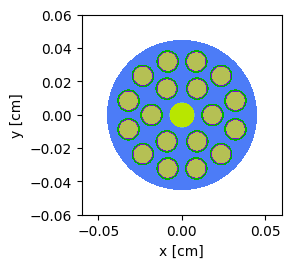

In [17]:
circlat.plot(width=(.12, .12), basis='xy')

In [18]:
# Define cylinder for fuel assembly
fuel_assembly = openmc.ZCylinder(r=.045, boundary_type='transmission')

# Define cell for fuel assembly
fuel_assembly_cell = openmc.Cell(name='Fuel Assembly', fill=circlat)
fuel_assembly_cell.region = -fuel_assembly & +z_plane_start & -z_plane_height

#Graphite Bricks
fuel_assembly_block = openmc.model.rectangular_prism(width=assembly_x, height=assembly_y)
fuel_assembly_block_cell = openmc.Cell(name='Graphite_bricks')
fuel_assembly_block_cell.fill = graphite
fuel_assembly_block_cell.region = fuel_assembly_block & +fuel_assembly & -z_plane_end & +z_min

fuel_assembly_universe = openmc.Universe(cells=[fuel_assembly_cell, fuel_assembly_block_cell])

/openmc_venv/lib/python3.11/site-packages/openmc/model/funcs.py:114: FutureWarning: The rectangular_prism(...) function has been replaced by the RectangularPrism(...) class. Future versions of OpenMC will not accept rectangular_prism.
  warn("The rectangular_prism(...) function has been replaced by the "


<Axes: xlabel='x [cm]', ylabel='y [cm]'>

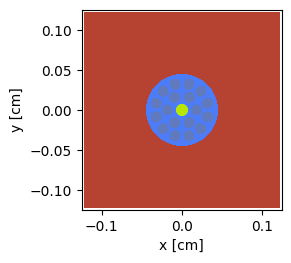

In [19]:
fuel_assembly_universe.plot(width=(.25, .25), basis='xy')

In [20]:
fuel_universe_lattice = openmc.RectLattice(name='Fuel Assembly')
fuel_universe_lattice.pitch = (.245833, .245833)
fuel_universe_lattice.lower_left = (0, 0)



fuel_universe_lattice.universes = [
    [concrete_assembly_universe if j < 17 or j >= 31 else fuel_assembly_universe for j in range(48)],  # Row 0
    [concrete_assembly_universe if j < 14 or j >= 34 else fuel_assembly_universe for j in range(48)],  # Row 1
    [concrete_assembly_universe if j < 12 or j >= 36 else fuel_assembly_universe for j in range(48)],  # Row 2
    [concrete_assembly_universe if j < 10 or j >= 38 else fuel_assembly_universe for j in range(48)],  # Row 3
    [concrete_assembly_universe if j < 9 or j >= 39 else fuel_assembly_universe for j in range(48)],   # Row 4
    [concrete_assembly_universe if j < 8 or j >= 40 else fuel_assembly_universe for j in range(48)],   # Row 5
    [concrete_assembly_universe if j < 7 or j >= 41 else fuel_assembly_universe for j in range(48)],   # Row 6
    [concrete_assembly_universe if j < 6 or j >= 42 else fuel_assembly_universe for j in range(48)],   # Row 7
    [concrete_assembly_universe if j < 5 or j >= 43 else fuel_assembly_universe for j in range(48)],   # Row 8
    [concrete_assembly_universe if j < 4 or j >= 44 else fuel_assembly_universe for j in range(48)],   # Row 9
    [concrete_assembly_universe if j < 3 or j >= 45 else fuel_assembly_universe for j in range(48)],   # Row 10
    [concrete_assembly_universe if j < 3 or j >= 45 else fuel_assembly_universe for j in range(48)],   # Row 11 (same as 10)
    [concrete_assembly_universe if j < 2 or j >= 46 else fuel_assembly_universe for j in range(48)],   # Row 12 (1 less than 11)
    [concrete_assembly_universe if j < 2 or j >= 46 else fuel_assembly_universe for j in range(48)],   # Row 13 (same as 12)
    [concrete_assembly_universe if j < 1 or j >= 47 else fuel_assembly_universe for j in range(48)],   # Row 14 (1 less than 13)
    [concrete_assembly_universe if j < 1 or j >= 47 else fuel_assembly_universe for j in range(48)],   # Row 15 (same as 14)
    [concrete_assembly_universe if j < 1 or j >= 47 else fuel_assembly_universe for j in range(48)],   # Row 16 (same as 14)
] + [
    # Rows 17-46 remain fully fuel
    [fuel_assembly_universe for _ in range(48)] for _ in range(14)
] + [
    # Row 47: first and last 17 columns as concrete, middle columns as fuel
    [concrete_assembly_universe if j < 1 or j >= 47 else fuel_assembly_universe for j in range(48)],   # Row 16 (same as 14)
    [concrete_assembly_universe if j < 1 or j >= 47 else fuel_assembly_universe for j in range(48)],   # Row 15 (same as 14)
    [concrete_assembly_universe if j < 1 or j >= 47 else fuel_assembly_universe for j in range(48)],   # Row 14 (1 less than 13)
    [concrete_assembly_universe if j < 2 or j >= 46 else fuel_assembly_universe for j in range(48)],   # Row 13 (same as 12)
    [concrete_assembly_universe if j < 2 or j >= 46 else fuel_assembly_universe for j in range(48)],   # Row 12 (1 less than 11)
    [concrete_assembly_universe if j < 3 or j >= 45 else fuel_assembly_universe for j in range(48)],   # Row 11 (same as 10)
    [concrete_assembly_universe if j < 3 or j >= 45 else fuel_assembly_universe for j in range(48)],   # Row 10
    [concrete_assembly_universe if j < 4 or j >= 44 else fuel_assembly_universe for j in range(48)],   # Row 9
    [concrete_assembly_universe if j < 5 or j >= 43 else fuel_assembly_universe for j in range(48)],   # Row 8
    [concrete_assembly_universe if j < 6 or j >= 42 else fuel_assembly_universe for j in range(48)],   # Row 7
    [concrete_assembly_universe if j < 7 or j >= 41 else fuel_assembly_universe for j in range(48)],   # Row 6
    [concrete_assembly_universe if j < 8 or j >= 40 else fuel_assembly_universe for j in range(48)],
    [concrete_assembly_universe if j < 9 or j >= 39 else fuel_assembly_universe for j in range(48)],
    [concrete_assembly_universe if j < 10 or j >= 38 else fuel_assembly_universe for j in range(48)],
    [concrete_assembly_universe if j < 12 or j >= 36 else fuel_assembly_universe for j in range(48)],
    [concrete_assembly_universe if j < 14 or j >= 34 else fuel_assembly_universe for j in range(48)],
    [concrete_assembly_universe if j < 17 or j >= 31 else fuel_assembly_universe for j in range(48)]  # Row 47
    
]




fuel_assembly_region = openmc.model.rectangular_prism(width=11.8, height=11.8, origin=(5.9, 5.9))
fuel_assembly_cell = openmc.Cell(name='core assembly cell', fill=fuel_universe_lattice, region=fuel_assembly_region)

core_assembly_universe = openmc.Universe(cells=[fuel_assembly_cell])

/openmc_venv/lib/python3.11/site-packages/openmc/model/funcs.py:114: FutureWarning: The rectangular_prism(...) function has been replaced by the RectangularPrism(...) class. Future versions of OpenMC will not accept rectangular_prism.
  warn("The rectangular_prism(...) function has been replaced by the "


<Axes: xlabel='x [cm]', ylabel='y [cm]'>

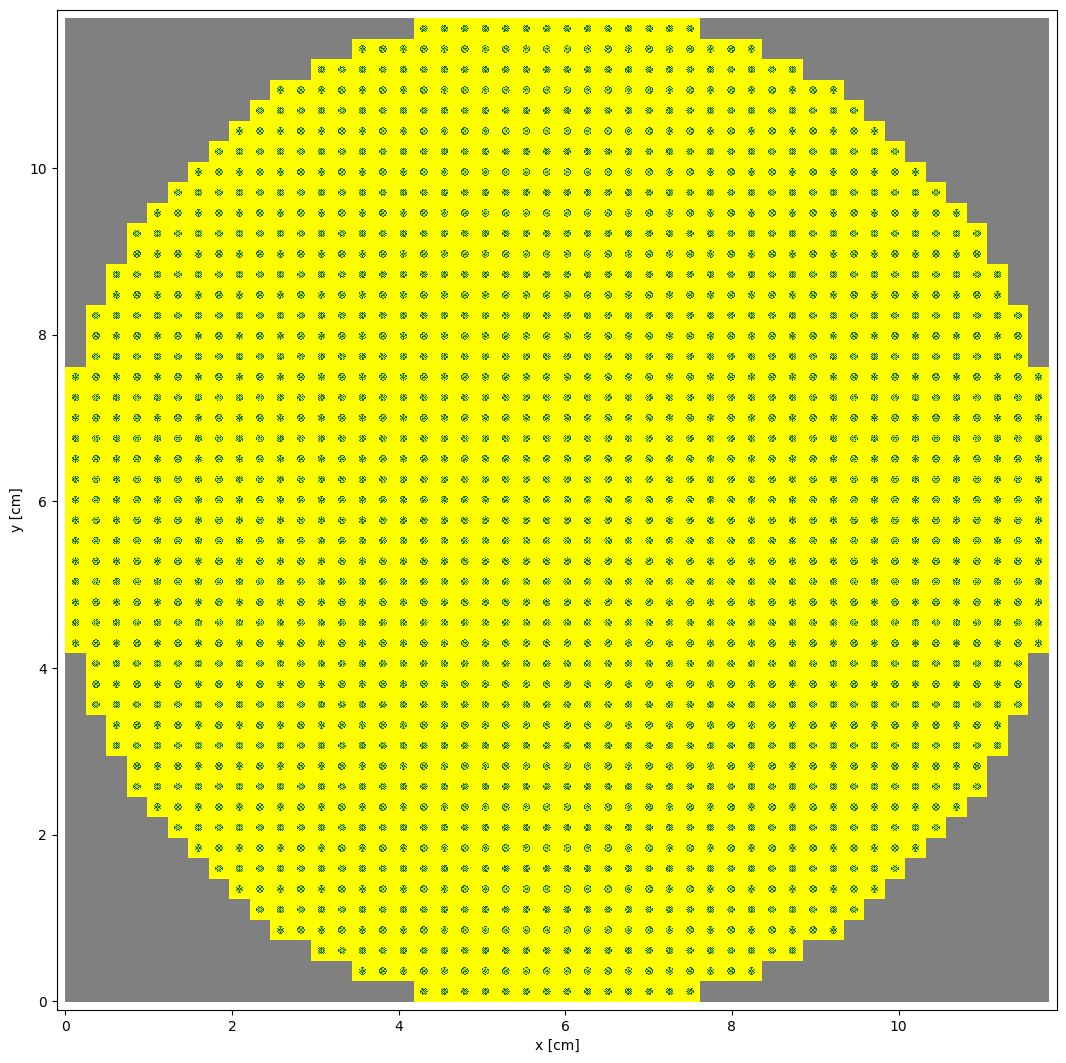

In [21]:
core_assembly_universe.plot(width=(12, 12), basis='xy', origin=(5.9, 5.9, 3.5), pixels=(1000, 1000), colors = {concrete_assembly_block_cell:'gray', fuel_assembly_block_cell:'yellow'})

In [88]:
fuel_universe_lattice = openmc.RectLattice(name='Fuel Assembly')
fuel_universe_lattice.pitch = (.245833, .245833)
fuel_universe_lattice.lower_left = (0, 0)

# Function to check if a position is valid for placing an absorber
def is_valid_for_absorber(row, col):
    # Check if the position is not concrete and is a fuel assembly
    if fuel_universe_lattice.universes[row][col] == fuel_assembly_universe:
        # Check if the position is not at the edges of the lattice structure
        if row == 0 or row == len(fuel_universe_lattice.universes) - 1 or col == 0 or col == 47:
            return False  # Cannot place absorbers at the edges of the lattice
        # Check if the position is not in the outermost ring of fuel assemblies that directly contact concrete
        # Directly contacting concrete means adjacent horizontally or vertically (not diagonally)
        for dr, dc in [(-1, 0), (1, 0), (0, -1), (0, 1)]:  # Check horizontal and vertical neighbors
            neighbor_row, neighbor_col = row + dr, col + dc
            if (0 <= neighbor_row < len(fuel_universe_lattice.universes) and
                0 <= neighbor_col < 48 and
                fuel_universe_lattice.universes[neighbor_row][neighbor_col] == concrete_assembly_universe):
                # If any horizontal or vertical neighbor is concrete, this position is invalid for an absorber
                return False
        # If no horizontal or vertical neighbors are concrete and it's not at the edge, the position is valid
        return True
    return False

# Function to place absorbers in all four diagonal directions from a given position
def place_absorbers_diagonally(start_row, start_col):
    # Directions: (row delta, col delta) for top-left, top-right, bottom-left, bottom-right
    directions = [(-1, -1), (-1, 1), (1, -1), (1, 1)]
    
    for dr, dc in directions:
        row, col = start_row + dr, start_col + dc
        # Skip the first position to ensure "every other" placement
        row += dr
        col += dc
        while 0 <= row < len(fuel_universe_lattice.universes) and 0 <= col < 48:
            if is_valid_for_absorber(row, col):
                fuel_universe_lattice.universes[row][col] = absorber_assembly_universe
                # Add the new absorber position to the queue for further propagation
                absorber_positions.append((row, col))
            row += dr * 2  # Skip every other position
            col += dc * 2

# Initialize the lattice with the existing rules
fuel_universe_lattice.universes = [
    [concrete_assembly_universe if j < 17 or j >= 31 else fuel_assembly_universe for j in range(48)],  # Row 0
    [concrete_assembly_universe if j < 14 or j >= 34 else fuel_assembly_universe for j in range(48)],  # Row 1
    [concrete_assembly_universe if j < 12 or j >= 36 else fuel_assembly_universe for j in range(48)],  # Row 2
    [concrete_assembly_universe if j < 10 or j >= 38 else fuel_assembly_universe for j in range(48)],  # Row 3
    [concrete_assembly_universe if j < 9 or j >= 39 else fuel_assembly_universe for j in range(48)],   # Row 4
    [concrete_assembly_universe if j < 8 or j >= 40 else fuel_assembly_universe for j in range(48)],   # Row 5
    [concrete_assembly_universe if j < 7 or j >= 41 else fuel_assembly_universe for j in range(48)],   # Row 6
    [concrete_assembly_universe if j < 6 or j >= 42 else fuel_assembly_universe for j in range(48)],   # Row 7
    [concrete_assembly_universe if j < 5 or j >= 43 else fuel_assembly_universe for j in range(48)],   # Row 8
    [concrete_assembly_universe if j < 4 or j >= 44 else fuel_assembly_universe for j in range(48)],   # Row 9
    [concrete_assembly_universe if j < 3 or j >= 45 else fuel_assembly_universe for j in range(48)],   # Row 10
    [concrete_assembly_universe if j < 3 or j >= 45 else fuel_assembly_universe for j in range(48)],   # Row 11
    [concrete_assembly_universe if j < 2 or j >= 46 else fuel_assembly_universe for j in range(48)],   # Row 12
    [concrete_assembly_universe if j < 2 or j >= 46 else fuel_assembly_universe for j in range(48)],   # Row 13
    [concrete_assembly_universe if j < 1 or j >= 47 else fuel_assembly_universe for j in range(48)],   # Row 14
    [concrete_assembly_universe if j < 1 or j >= 47 else fuel_assembly_universe for j in range(48)],   # Row 15
    [concrete_assembly_universe if j < 1 or j >= 47 else fuel_assembly_universe for j in range(48)],   # Row 16
] + [
    [fuel_assembly_universe for _ in range(48)] for _ in range(14)  # Rows 17-46
] + [
    [concrete_assembly_universe if j < 1 or j >= 47 else fuel_assembly_universe for j in range(48)],   # Row 47
    [concrete_assembly_universe if j < 1 or j >= 47 else fuel_assembly_universe for j in range(48)],   # Row 46
    [concrete_assembly_universe if j < 1 or j >= 47 else fuel_assembly_universe for j in range(48)],   # Row 45
    [concrete_assembly_universe if j < 2 or j >= 46 else fuel_assembly_universe for j in range(48)],   # Row 44
    [concrete_assembly_universe if j < 2 or j >= 46 else fuel_assembly_universe for j in range(48)],   # Row 43
    [concrete_assembly_universe if j < 3 or j >= 45 else fuel_assembly_universe for j in range(48)],   # Row 42
    [concrete_assembly_universe if j < 3 or j >= 45 else fuel_assembly_universe for j in range(48)],   # Row 41
    [concrete_assembly_universe if j < 4 or j >= 44 else fuel_assembly_universe for j in range(48)],   # Row 40
    [concrete_assembly_universe if j < 5 or j >= 43 else fuel_assembly_universe for j in range(48)],   # Row 39
    [concrete_assembly_universe if j < 6 or j >= 42 else fuel_assembly_universe for j in range(48)],   # Row 38
    [concrete_assembly_universe if j < 7 or j >= 41 else fuel_assembly_universe for j in range(48)],   # Row 37
    [concrete_assembly_universe if j < 8 or j >= 40 else fuel_assembly_universe for j in range(48)],   # Row 36
    [concrete_assembly_universe if j < 9 or j >= 39 else fuel_assembly_universe for j in range(48)],   # Row 35
    [concrete_assembly_universe if j < 10 or j >= 38 else fuel_assembly_universe for j in range(48)],  # Row 34
    [concrete_assembly_universe if j < 12 or j >= 36 else fuel_assembly_universe for j in range(48)],  # Row 33
    [concrete_assembly_universe if j < 14 or j >= 34 else fuel_assembly_universe for j in range(48)],  # Row 32
    [concrete_assembly_universe if j < 17 or j >= 31 else fuel_assembly_universe for j in range(48)]   # Row 31
]

# Initialize a queue with the starting absorber position
absorber_positions = [(1, 17)]  # Starting position (row 1, column 17)

# Propagate the absorber pattern from all positions in the queue
while absorber_positions:
    current_row, current_col = absorber_positions.pop(0)
    place_absorbers_diagonally(current_row, current_col)


fuel_assembly_region = openmc.model.rectangular_prism(width=11.8, height=11.8, origin=(5.9, 5.9))
fuel_assembly_cell = openmc.Cell(name='core assembly cell', fill=fuel_universe_lattice, region=fuel_assembly_region)

core_assembly_universe = openmc.Universe(cells=[fuel_assembly_cell])

/openmc_venv/lib/python3.11/site-packages/openmc/model/funcs.py:114: FutureWarning: The rectangular_prism(...) function has been replaced by the RectangularPrism(...) class. Future versions of OpenMC will not accept rectangular_prism.
  warn("The rectangular_prism(...) function has been replaced by the "


<Axes: xlabel='x [cm]', ylabel='y [cm]'>

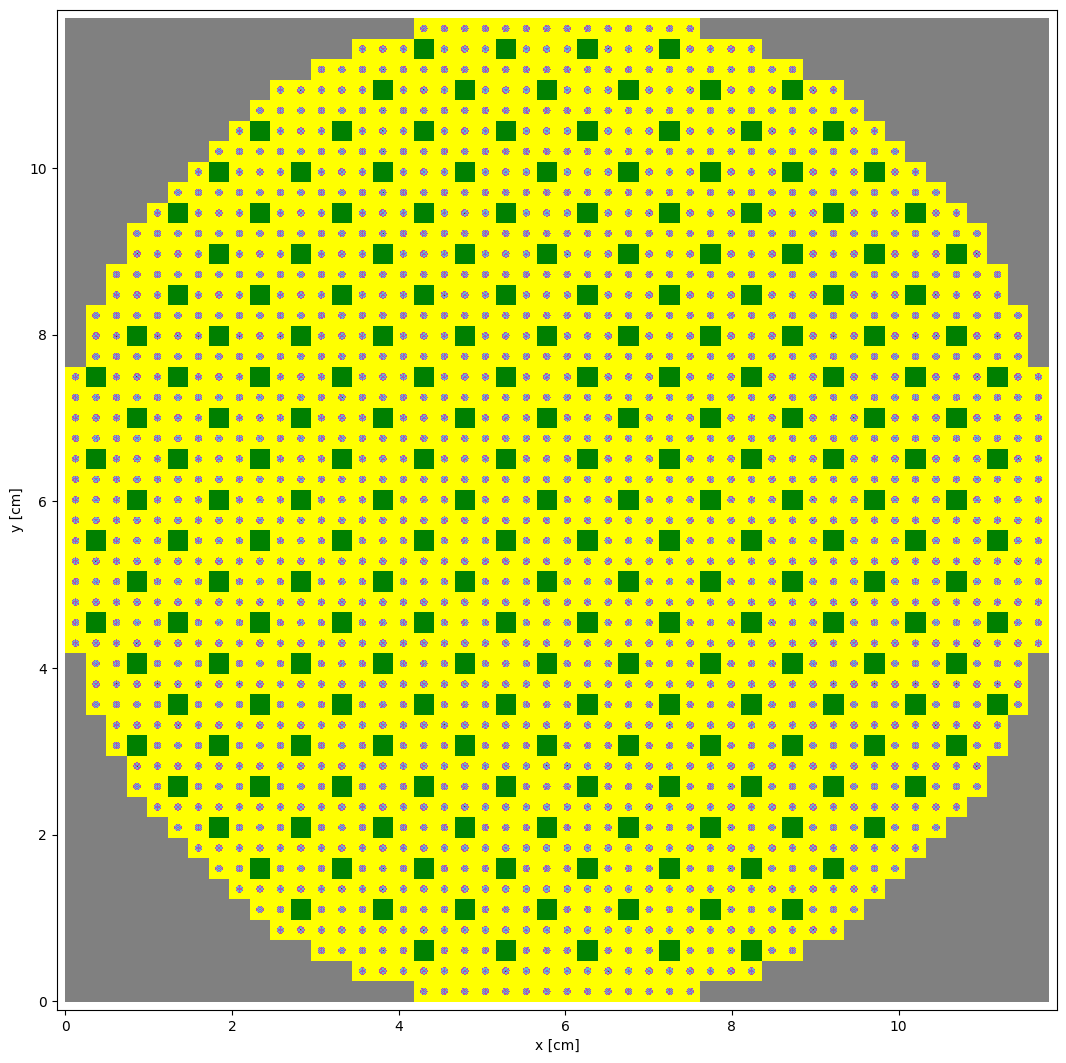

In [89]:
core_assembly_universe.plot(width=(12, 12), basis='xy', origin=(5.9, 5.9, 3.5), pixels=(1000, 1000), colors = {concrete_assembly_block_cell:'gray', fuel_assembly_block_cell:'yellow', absorber_assembly_block_cell:'green'})

In [90]:
# OpenMC simulation parameters

batches = 20
inactive = 10
particles = 10000

settings_file = openmc.Settings()
settings_file.batches = batches
settings_file.inactive = inactive
settings_file.particles = particles

settings_file.export_to_xml()

model = openmc.model.Model(geometry, materials_file, settings_file)
model.run(threads=16)

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

PosixPath('/root/openmc-items/statepoint.20.h5')